https://app.dominodatalab.com/u/fonnesbeck/gp_showdown/view/GP+Showdown.ipynb

In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
GPXfile='Lunch_Walk.gpx'
data = open(GPXfile).read()

In [3]:
lat = np.array(re.findall(r'lat="([^"]+)',data),dtype=float)
lon = np.array(re.findall(r'lon="([^"]+)',data),dtype=float)
time = re.findall(r'<time>([^\<]+)',data)
dt = pd.to_datetime(time)
s = dt.astype(int)

coords = np.array(list(zip(lat,lon,time,dt,s)))


coords = coords[::1]
coords[5]


coords.shape

(6614, 5)

In [4]:
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)


# gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

(1.0,
 51.512325,
 0.0,
 -0.187665,
 (6614, 1),
 (6614, 2, 1),
 [1.6089933929680983e+18, 3279197928805.907])

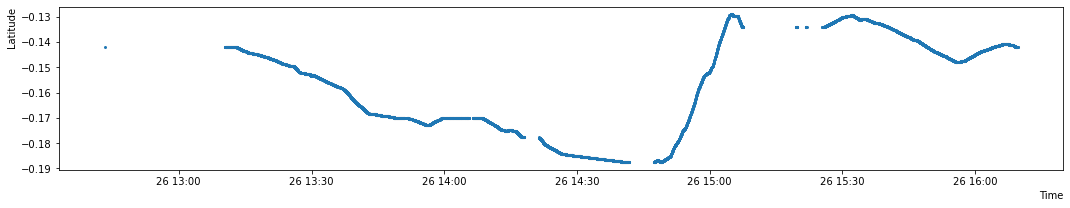

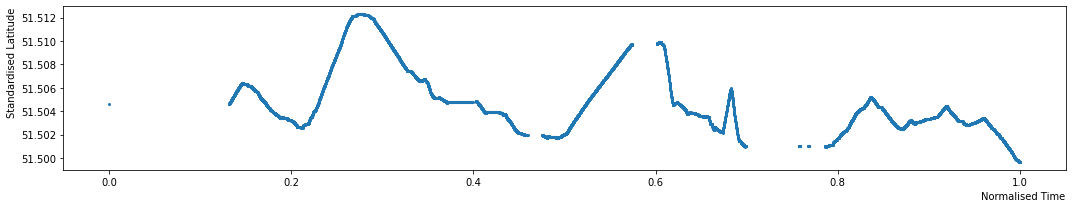

In [115]:
X = coords[:, -2].reshape(-1, 1)
Xsec = coords[:, -1].reshape(-1, 1).astype(np.float64)



Y0 = coords[:, 0].reshape(-1, 1).astype(np.float64)
Y1 = coords[:, 1].reshape(-1, 1).astype(np.float64)

Y=np.array(list(zip(Y0,Y1)))

plt.figure(figsize=(18,3))
_ = plt.plot(X, Y[:,1], ".", mew=.005)
plt.xlabel('Time', horizontalalignment='right', x=1.0)
plt.ylabel('Latitude', horizontalalignment='right', y=1.0)
# plt.tight_layout()


xx = [Xsec.min(),Xsec.max()]


#centre time data - Cholesky decomposition was not successful.
Xm = Xsec.mean()
Xs = Xsec.std()

# Xsec = (Xsec - Xsec.mean()) / Xsec.std()
Xsec -= Xsec.min()
Xsec /= Xsec.max()




# Ym = Y.mean()
# Ys = Y.std()
# Yv = (Y - Y.mean()) / Y.std()

Yv=Y

plt.figure(figsize=(15,3))

_ = plt.plot(Xsec, Y[:,0], ".", mew=.005)
plt.xlabel('Normalised Time', horizontalalignment='right', x=1.0)
plt.ylabel('Standardised Latitude', horizontalalignment='right', y=1.0)
plt.tight_layout()
# plt.figure()

# Y = coords[:, 1].reshape(-1, 1)
# _ = plt.plot(X, Y, ".", mew=.005)
# plt.title('Lon')

'''

Centering (and 'whitening' i.e. unit standard deviation) is equivalent to changing the hyperparameter settings. If you whiten the data then the gpflow defaults are probably going to be ok, but if you don't whiten they the hyperparameters can be grossly misspecified and you may have an ill-conditioned problem. If you do not whiten the data then you need to be more careful about hyperparameter initialization.
'''
Xsec.max(),Y.max(),Xsec.min(),Y.min(),Xsec.shape,Y.shape,[Xm,Xs]


In [6]:

Yi = Yv.astype(np.float64)
#coords[:, 0].reshape(-1, 1).astype(np.float64)
Xi = coords[:, -1].reshape(-1, 1).astype(np.float64)

second = 1000000000

resolution = 0.0008
timegap = 60*second


Xarr = []
Yarr = []
Yold = [-999,-999]
Xold = -999
for j in range(len(Xi)):
    i = Yi[j][0][0]
    k = Yi[j][1][0]
    if abs(i-Yold[0])>resolution:
        Yarr.append([i,k])
        Yold=[i,k]
        Xold = Xi[j]
        Xarr.append(Xi[j])
    elif abs(Xi[j]-Xold)>timegap:
        Yarr.append([i,k])
        Yold=[i,k]
        Xold = Xi[j]
        Xarr.append(Xi[j])
    elif abs(k-Yold[1])>resolution:
        Yarr.append([i,k])
        Yold=[i,k]
        Xold = Xi[j]
        Xarr.append(Xi[j])
 
        
len(Yarr)

Xarr= np.array(Xarr).reshape(-1, 1).astype(np.float64)
Yarr= np.array(Yarr)#.reshape(-1, 1).astype(np.float64)


Xarr -= Xarr.min()
Xarr /= Xarr.max()

means=[]
scales = []
for q in [0,1]:

    scale = 1/Yarr[:,q].std()
    Yarr[:,q]=Yarr[:,q]*scale #1/resolution
    scales.append(scale)
    
    Ym = Yarr[:,q].mean()
    Yarr[:,q] = Yarr[:,q]-Ym
    means.append(Ym)
    # Yarr*=100#1/resolution
    

    # Ym = Yarr.mean()
    # Ys = Yarr.std()
    # Yarr = (Yarr - Yarr.mean()) / Yarr.std()

Yarr.shape


X=Xarr
Y=Yarr
Y.shape,means,scales,Yarr[:,0],q
Yi

array([[[51.504613],
        [-0.141894]],

       [[51.504624],
        [-0.141901]],

       [[51.504633],
        [-0.141906]],

       ...,

       [[51.499653],
        [-0.141922]],

       [[51.49966 ],
        [-0.141926]],

       [[51.499661],
        [-0.141926]]])

In [7]:
# N = 100  # number of points
# D = 1  # number of input dimensions
# M = 15  # number of inducing points
# L = 2  # number of latent GPs

MAXITER = ci_niter(2000)
D = 1  # number of input dimensions
P = len(Y[0])  # number of observations = output dimensions
M = len(Y)  # number of inducing points

# def generate_data(N=100):
#     X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
#     G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
#     W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
#     F = np.matmul(G, W)  # N x P
#     Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]

#     return X, Y

# X, Y = data = generate_data(N)
Zinit = np.linspace(0, 1, M)[:, None]

In [8]:
# gpf=gpflow
# Create list of kernels for each output
kern_list = [gpflow.kernels.Matern52() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpflow.inducing_variables.SharedIndependentInducingVariables(
    gpflow.inducing_variables.InducingPoints(Z)
)

# create SVGP model as usual and optimize
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.GaussianMC(), inducing_variable=iv, num_latent_gps=P)

print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(233, 1)",float64,[[0....
SVGP.q_mu,Parameter,Identity,,True,"(233, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 233, 233)",float64,"[[[1., 0., 0...."


In [91]:
kernel =  gpflow.kernels.Matern52( variance=1, lengthscales=1.2)+ gpflow.kernels.White() #+gpflow.kernels.Exponential() 

m = gpflow.models.GPR(data=(Xarr, Yarr), kernel=kernel, mean_function=None)
m.trainable_variables

m.likelihood.variance.assign(0.01)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.684181
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.0189661
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,7.09031e-05
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00011494


In [92]:
Y.shape,X.shape

((233, 2), (233, 1))

In [93]:
data = (X,Y)

def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
#         model.training_loss_closure(data),
        m.training_loss,
        variables=model.trainable_variables,
#         method="l-bfgs-b",
        options={"disp": True, "maxiter": MAXITER},
    )


optimize_model_with_scipy(m)

In [1]:
def plot_model(m, lower=0, upper=1):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]

    for i in range(pY.shape[1]):
        plt.figure()
#         plt.plot(X, Y, "x")
        plt.gca().set_prop_cycle(None)
        plt.plot(pX, pY[:,i])
        
        
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"")
    plt.figure()
    plt.plot(Z, Z * 0.01, "o")

<Figure size 864x216 with 0 Axes>

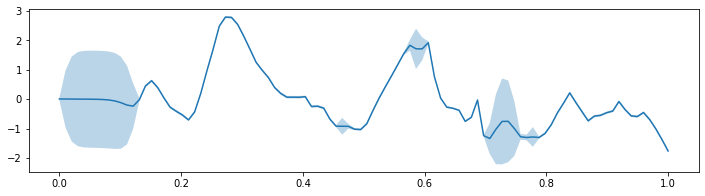

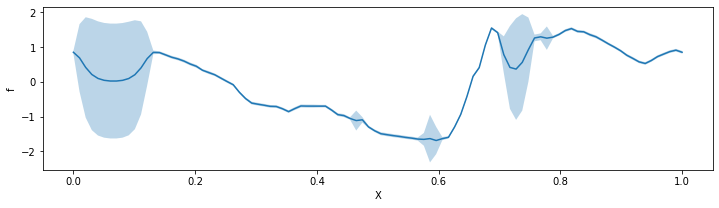

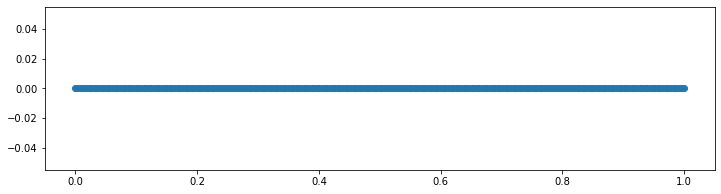

In [95]:
plt.clf();plot_model(m)

In [96]:
m.predict_y(np.array([[.4]]))

(<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[ 0.0971069, -0.6992663]])>,
 <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.00146983, 0.00146983]])>)

In [97]:
Y.min(),Y.max()

(-1.7656262751588656, 2.8168008270331484)

In [98]:

#save
saver= gpflow.saver.Saver()
saver.save('./gpe_lonlat', m)

AttributeError: module 'gpflow' has no attribute 'saver'

In [117]:
import tensorflow as tf
m.predict_f_compiled = tf.function(
    m.predict_f, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)]
)

#model load comparison 



xx=[1,2]

samples_input = np.array([[0.4]]).astype(np.float64)
samples_input = tf.convert_to_tensor(samples_input, dtype=np.float64)

original_result = m.predict_f_compiled(samples_input)


@tf.function(input_signature=[tf.TensorSpec(shape=None, dtype=tf.float64)])
def test(x):
    
    return m.predict_f_compiled(x),xx

m.test=test

# m.add_to_collection('CONSTANTS', tf.constant(value=66, name=test))


save_dir = './gpe_save'
tf.saved_model.save(m, save_dir)


INFO:tensorflow:Assets written to: ./gpe_save/assets


INFO:tensorflow:Assets written to: ./gpe_save/assets


In [118]:
l = tf.saved_model.load(save_dir)
lr = l.predict_f_compiled(samples_input)

m.predict_y(np.array([[0.4]]))

lr

(<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[ 0.0971069, -0.6992663]])>,
 <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.00135489, 0.00135489]])>)

In [119]:
m.predict_f(np.array([[0.2]]))

(<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[-0.49508883,  0.45704016]])>,
 <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.00024766, 0.00024766]])>)

In [120]:
l.predict_f_compiled(np.array([[0.2]]))

(<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[-0.49508883,  0.45704016]])>,
 <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.00024766, 0.00024766]])>)

In [123]:
l.test(np.array([[0.2]]))

((<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[-0.49508883,  0.45704016]])>,
  <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.00024766, 0.00024766]])>),
 [<tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=2>])

In [122]:
xx=[3,5]